In [478]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
from scipy import stats

base_dir = '/Users/simon/git/ms1fun/'
sys.path.append(base_dir + 'code')
sys.path.append(base_dir + 'dbs')

from corr_cluster import Peak,BetaLike,CorrCluster
from formula import Formula
import pylab as plt
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Grab some files

In [631]:
files = []

prefix = '/Users/simon/Downloads/Beer3_mzXML_mzML_files/PositiveMode/Beer3Full/csv/'
filename = 'Beer_3_Full1'
files.append((prefix,filename,False))

In [632]:
prefix = '/Users/simon/Dropbox/BioResearch/MS2LDA/Urine/conv/csv/'
filename = 'Urine_37_fullscan1_POS'
files.append((prefix,filename,False))

In [633]:
prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/StandardData140606/csv/'
filename = 'batch1_Std_1_1'
files.append((prefix,filename,True))

filename = 'batch1_Std_1_2'
files.append((prefix,filename,True))

filename = 'batch1_Std_2_1'
files.append((prefix,filename,True))

filename = 'batch1_Std_2_2'
files.append((prefix,filename,True))

In [634]:
import transformation
transformations = transformation.load_from_file(base_dir + 'dbs/pos_transformations_reduced.yml')
print "Loaded " + str(len(transformations)) + " transformations"

Loaded 72 transformations


Define the molecule object

In [635]:
PROTON = 1.00727645199076


class Mol(object):
    def __init__(self,name,formula,mass,rt):
        self.name = name.strip()
        self.formula = formula.strip()
        self.mass = mass
        self.rt = rt
    def __str__(self):
        return "{} ({},{})".format(self.name,self.mass,self.rt)
    def __repr__(self):
        return "{} ({},{})".format(self.name,self.mass,self.rt)

Load the standards database from file

In [636]:
std_file = base_dir + 'dbs/std1_20130822_130526.csv'
std_file = '/Users/simon/Downloads/Beer3_mzXML_mzML_files/Std1_1_20150422_150810_combined.csv'
mols = []
with open(std_file,'rU') as f:
    for i in range(9):
        f.readline() # remove heads
    for line in f:
        split_line = line.split(',')
        polarity = split_line[4]
        rts = split_line[9] # observed, not predicted
        if rts == '-':
            rt = 0.0
        else:
            rt = float(rts)
        if polarity == '+' and rt > 0.0:
            name = split_line[2]
            formula = split_line[3]
            f = Formula(formula)
            new_mol = Mol(name,formula,f.compute_exact_mass(),rt*60.0)
            mols.append(new_mol)
mols = sorted(mols,key = lambda x: x.mass)
for mol in mols:
    print mol

1_3-Diaminopropane (74.0843983319,738.6)
Glycine (75.0320284101,658.8)
1-Aminopropan-2-ol (75.0684139166,938.4)
Mercaptoethanol (78.0139355049,1307.4)
beta-Alanine (89.0476784744,646.2)
L-Alanine (89.0476784744,633.6)
Glycerol (92.0473441234,480.0)
Phenol (94.0418648149,250.8)
1-Aminocyclopropane-1-carboxylate (101.047678474,569.4)
2-Aminobutan-4-olide (101.047678474,379.8)
4-Aminobutanoate (103.063328539,649.2)
Choline (103.099714045,915.0)
L-2_3-Diaminopropanoate (104.058577512,654.6)
L-Serine (105.042593097,657.6)
Phenylhydrazine (108.068748268,301.8)
cytosine (111.043261799,552.6)
Uracil (112.027277383,463.2)
Creatinine (113.058911863,496.8)
L-Proline (115.063328539,580.8)
Selenomethionine (117.078978603,538.8)
L-Valine (117.078978603,570.6)
Betaine (117.078978603,534.6)
L-2_4-Diaminobutanoate (118.074227576,743.4)
L-Threonine (119.058243161,619.2)
L-homoserine (119.058243161,637.8)
L-cysteine (121.019749164,612.6)
Nicotinamide (122.048012825,400.8)
Nicotinate (123.03202841,412.2)


In [637]:
bl = BetaLike()
clusterings = {}
for f in files:

    filename = f[1]
    prefix = f[0]
    print "Running file " + filename
    csvfile = prefix + filename + '.csv'
    matfile = prefix + filename + '.corr.mat'
    signalfile = prefix + filename + '.peakml.signal'
    # Simon is an idiot...remember to change 'correct = True' or 'correct = False' 
    # coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.7,correct=True)
    coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.7,correct=f[2])
    clusterings[filename] = coc

Running file Beer_3_Full1
1421.38000488
Loaded 7863 peaks
Reading shape correlations from /Users/simon/Downloads/Beer3_mzXML_mzML_files/PositiveMode/Beer3Full/csv/Beer_3_Full1.corr.mat
Greedy clustering done, resulting in 1116 clusters
Running file Urine_37_fullscan1_POS
Loaded 7733 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/MS2LDA/Urine/conv/csv/Urine_37_fullscan1_POS.corr.mat
Greedy clustering done, resulting in 1237 clusters
Running file batch1_Std_1_1
1357.622802
Loaded 6150 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/StandardData140606/csv/batch1_Std_1_1.corr.mat
Greedy clustering done, resulting in 1343 clusters
Running file batch1_Std_1_2
Loaded 5624 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/StandardData140606/csv/batch1_Std_1_2.corr.mat
Greedy clustering done, resulting in 1288 clusters
Running file batch1_Std_2_1
1387.3
Loaded 6355 peaks
Reading shape correlation

Find the protonated transformation for baselining

In [638]:
protonated = [t for t in transformations if t.name=='M+H'][0]

Functions for matching peaks to a database

In [639]:
def hit(m1,m2,rt1,rt2,mtol=20,rttol=1):
    if 1e6*np.abs(m1-m2)/m2 < mtol and np.abs(rt1-rt2)<rttol:
        return True
    else:
        return False
    
def get_hits(peaks,mols,transformations,mtol=20,rttol = 120.0):
    hits = {}
    for mol in mols:
        for peak in peaks:
            for t in transformations:
                if hit(t.transform(peak),mol.mass,peak.rt,mol.rt,mtol = mtol,rttol = rttol):
                    if mol in hits:
                        if np.abs(peak.rt - mol.rt) < np.abs(hits[mol].rt - mol.rt):
                            hits[mol] = peak
                    else:
                        hits[mol] = peak
    return hits

Perform the voting...

In [640]:
from voter import Voter,PeakGroup
groups = {}
for f in files:
    v = Voter(transformations)
    filename = f[1]
    print "Performing voting on file {}".format(filename)
    file_groups = []
    for cluster in clusterings[filename].clusters:
        file_groups += v.make_groups(cluster.members)
    groups[filename] = file_groups

Performing voting on file Beer_3_Full1
Performing voting on file Urine_37_fullscan1_POS
Performing voting on file batch1_Std_1_1
Performing voting on file batch1_Std_1_2
Performing voting on file batch1_Std_2_1
Performing voting on file batch1_Std_2_2


In [641]:
def get_M_hits(groups,mols,use_max_vote = True):
    hits = {}
    for g in groups:
        for mol in mols:
            if hit(mol.mass,g.M,mol.rt,g.rt,mtol=10,rttol=10):
                if not mol in hits:
                    hits[mol] = g
                else:
                    if use_max_vote:
                        if g.vote > hits[mol]:
                            hits[mol] = g
                    else:
                        current = hits[mol]
                        if np.abs(g.rt - mol.rt) < np.abs(current.rt - mol.rt):
                            hits[mol] = g
                
    return hits


In [642]:
all_hits = {}
for f in files:
    filename = f[1]
    all_hits[filename] = get_M_hits(groups[filename],mols,use_max_vote = True)

    

Output a file with the groups (and peaks that form them)

In [643]:
# Sort the groups according to votes (top ones first)
for f in files:
    filename = f[1]
    outpre = filename

    temp_groups = sorted(groups[filename],key = lambda x:x.vote,reverse=True)
    outfile = outpre + '_by_vote.txt'
    

    with open(outfile,'w') as f:
        for i,group in enumerate(temp_groups):
            line = "vote: {}, M: {}\n".format(group.vote,group.M)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')
            
    temp_groups = sorted(groups[filename],key = lambda x:x.M)
    outfile = outpre + '_by_M.txt'
    
    with open(outfile,'w') as f:
        for i,group in enumerate(temp_groups):
            line = "vote: {}, M: {}\n".format(group.vote,group.M)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')

    with open(outpre + '_matched_std.txt','w') as f:
        for mol in all_hits[filename]:
            group = all_hits[filename][mol]
            line = "{} (vote={})\n".format(mol,group.vote)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')


    include_singletons = False
    trans_counts = {}
    tot = 0
    for tr in transformations:
        trans_counts[tr] = 0
    for group in groups[filename]:
        if not include_singletons:
            if len(group.members) == 1:
                continue
        for p,t,_ in group.members:
            trans_counts[t] += 1
            tot += 1

    with open(outpre + '_tran_counts.txt','w') as f:
        for tr in sorted(transformations,key = lambda x: x.vote, reverse=True):
            line = "{},{},{:.4f}\n".format(tr,trans_counts[tr],trans_counts[tr]/(1.0*tot))
            f.write(line)

List the transformations and their votes

In [526]:
sorted_t = sorted(transformations,key = lambda x:x.vote,reverse=True)
for tr in sorted_t:
    print tr,tr.vote

M+H 1.0
M+H[C13] 0.9
M+H[2C13] 0.9
M+K 0.6
M+Na 0.6
M+K[C13] 0.54
M+K[2C13] 0.54
M+Na[C13] 0.54
M+Na[2C13] 0.54
[M-H2O]+H 0.5
[M-CO]+H 0.5
[M-H2O]+H[C13] 0.45
[M-H2O]+H[2C13] 0.45
[M-CO]+H[C13] 0.45
[M-CO]+H[2C13] 0.45
2M+H 0.4
M+2H 0.4
M+ACN+H 0.4
M+H+CH3OH 0.4
M+NH4 0.4
2M+H[C13] 0.36
2M+H[2C13] 0.36
M+2H[C13] 0.36
M+2H[2C13] 0.36
M+ACN+H[C13] 0.36
M+ACN+H[2C13] 0.36
M+H+CH3OH[C13] 0.36
M+H+CH3OH[2C13] 0.36
M+NH4[C13] 0.36
M+NH4[2C13] 0.36
[M-H2O]+K 0.3
[M-CO]+K 0.3
[M-H2O]+Na 0.3
[M-CO]+Na 0.3
[M-H2O]+K[C13] 0.27
[M-H2O]+K[2C13] 0.27
[M-CO]+K[C13] 0.27
[M-CO]+K[2C13] 0.27
[M-H2O]+Na[C13] 0.27
[M-H2O]+Na[2C13] 0.27
[M-CO]+Na[C13] 0.27
[M-CO]+Na[2C13] 0.27
[2M-H2O]+H 0.2
[2M-CO]+H 0.2
[M-H2O]+2H 0.2
[M-CO]+2H 0.2
[M-H2O]+ACN+H 0.2
[M-CO]+ACN+H 0.2
[M-H2O]+H+CH3OH 0.2
[M-CO]+H+CH3OH 0.2
[M-H2O]+NH4 0.2
[M-CO]+NH4 0.2
[2M-H2O]+H[C13] 0.18
[2M-H2O]+H[2C13] 0.18
[2M-CO]+H[C13] 0.18
[2M-CO]+H[2C13] 0.18
[M-H2O]+2H[C13] 0.18
[M-H2O]+2H[2C13] 0.18
[M-CO]+2H[C13] 0.18
[M-CO]+2H[2C13] 0.18
[M-

Plot intensity versus group vote

In [527]:
peaki = []
gvote = []
for g in groups:
    for (p,_,_) in g.members:
        peaki.append(p.intensity)
        gvote.append(g.vote)

0.117462813251 1.43902321206e-25


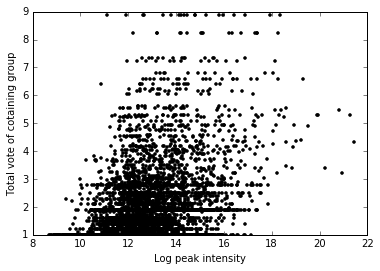

In [528]:
plt.figure()
plt.plot(np.log(peaki),gvote,'k.')
plt.xlabel('Log peak intensity')
plt.ylabel('Total vote of cotaining group')
from scipy.stats.stats import pearsonr
r,p = pearsonr(peaki,gvote)
print r,p


Look for groups that have C13 for two adducts, compute the ratios between the mono-isotope and the C13 and plot them against each other. They should lie close to the y=x line.

18


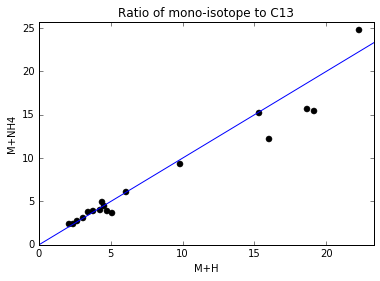

In [529]:
#Change these names to see other things
add1name = "M+H"
add2name = "M+NH4"

add1 = [t for t in transformations if t.name==add1name][0]
add1C13 = [t for t in transformations if t.name==add1name + "[C13]"][0]

add2 = [t for t in transformations if t.name==add2name][0]
add2C13 = [t for t in transformations if t.name==add2name + "[C13]"][0]




ratios = {}
for g in groups:
    # Extract the transformations
    add1I = -1
    add1C13I = -1
    add2I = -1
    add2C13I = -1
    for p,t,_ in g.members:
        if t == add1:
            add1I = p.intensity
        if t == add1C13:
            add1C13I = p.intensity
        if t == add2:
            add2I = p.intensity
        if t == add2C13:
            add2C13I = p.intensity



    if add1I > 0 and add1C13I > 0 and add2I > 0 and add2C13I > 0:
        ratios[g] = (add1I/add1C13I,add2I/add2C13I)
        if ratios[g][1] > 60:
            print g.M,ratios[g]
    


print len(ratios)

# Plot them
a = []
b = []
for r in ratios:
    a.append(ratios[r][0])
    b.append(ratios[r][1])

a = np.array(a)
b = np.array(b)

plt.figure()
plt.plot(a,b,'ko')
plt.xlim([0,a.max()+1])
plt.ylim([0,b.max()+1])
plt.plot([0,a.max()+1],[0,a.max()+1])

plt.xlabel(add1)
plt.ylabel(add2)
plt.title('Ratio of mono-isotope to C13')

In [453]:
print add2

M+H+CH3OH


In [461]:
singletons = []
non_singletons = []
for g in groups:
    if len(g.members) == 1:
        singletons.append(g.members[0][0].intensity)
    else:
        for p,_,_ in g.members:
            non_singletons.append(p.intensity)

singletons = np.array(singletons)
non_singletons = np.array(non_singletons)
print "{:.2e},{:.2e}".format(singletons.mean(),non_singletons.mean())

4.08e+05,4.63e+06


(array([   1.,   25.,  211.,  661.,  981.,  701.,  457.,  273.,  146.,   72.]),
 array([ 3.77028329,  4.13706178,  4.50384028,  4.87061877,  5.23739727,
         5.60417577,  5.97095426,  6.33773276,  6.70451125,  7.07128975,
         7.43806824]),
 <a list of 10 Patch objects>)

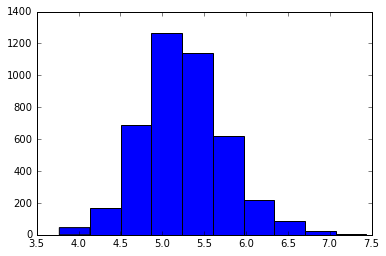

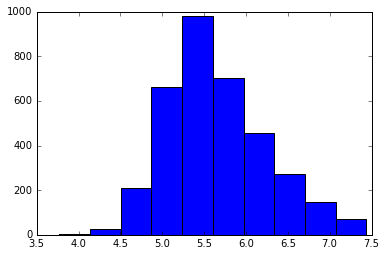

In [469]:
plt.figure()
(a,b,c) = plt.hist(np.log10(singletons))
plt.figure()
plt.hist(np.log10(non_singletons),bins=b)

In [474]:
print np.sum(singletons < 5e5)

3515


In [471]:
print len(singletons)

4267


In [476]:
print len(groups) - np.sum(singletons < 5e5),len(coc.Z)

2016 7863


In [477]:
print np.sum(non_singletons < 5e5)

2089


Compare the standards found in two different outputs

In [585]:
print filename

Beer_3_Full1


In [653]:
file1 = files[4][1]
file2 = files[5][1]
compare1 = all_hits[file1]
compare2 = all_hits[file2]
print file1,file2

batch1_Std_2_1 batch1_Std_2_2


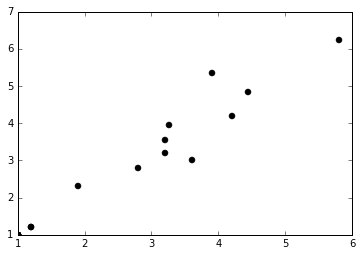

In [654]:
votes1 = []
votes2 = []
with open('{}_{}_std_comparison.txt'.format(file1,file2),'w') as f:
    for mol in compare1:
        if mol in compare2:
            group1 = compare1[mol]
            group2 = compare2[mol]
            
            votes1.append(group1.vote)
            votes2.append(group2.vote)
            
            line = "{}\n".format(mol)
            f.write(line)
            line = "{} Vote: {}, {} Vote: {}\n".format(file1,group1.vote,file2,group2.vote)
            f.write(line)
            
            line = "{}\n".format(file1)
            f.write(line)
            
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group1.members,key = lambda x: x[0].intensity,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')
            
            line = "{}\n".format(file2)
            f.write(line)
            
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group2.members,key = lambda x: x[0].intensity,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')
            
            f.write('\n\n\n')

            
plt.plot(votes1,votes2,'ko')


In [604]:
r,p = pearsonr(beervotes,urinevotes)
print r,p

0.401649261948 0.0517209016557


119.058249176119.058245197119.058230572119.058224245119.058192905
92.04736948192.047360524792.047347466292.047338191492.0473166737
174.100488504174.100381449
169.073952118169.073812836169.073746967169.073709244
105.042595579105.04258218105.042545329
179.079310182179.079292806179.079291345179.079287414179.079263888179.079243158179.07683799179.076526047
115.063379786115.063299053115.063296341115.063241104115.063155887
155.069498213155.069468092155.069399106
145.110285564145.110214387
297.089578858297.089222526297.087968209
190.095367232
89.047675295589.047669887289.04765553689.0476145733
131.058267792131.058254507131.05821493131.058189995131.058160652131.058158043131.058094661131.055727062
221.090090083221.089986733221.089959187221.089867326221.089831466221.089811911221.089809943221.089794026221.089744033221.087381717221.087155974221.087084892
132.053454876132.053443703132.053435018132.053431375132.053248096
118.074234945118.074172502
267.096493021267.096456569267.095229333
117.079010921